# <center> Recommender System </center>

## Preparation

Connect to drive (if needed)

In [1]:
import os
import tensorflow as tf
from tensorflow.python.client import device_lib

DRIVE_DIR = ""
USING_DRIVE = False
if USING_DRIVE:
    # from google.colab import drive
    # drive.mount('/content/drive')
    DRIVE_DIR = "drive/My Drive/Bangkit/"

# Check GPU
devices = tf.config.experimental.list_physical_devices()
for device in devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


Constants

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

LOG_NAME = "recommender-avgrating-morecomplex"
REMARK = "Try more complex model with longer epoch"
BATCH_SIZE = 512
LEARNING_RATE = 1e-5
EPOCH = 300
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS_FN = tf.keras.losses.MeanSquaredError()

Log dir

In [3]:
DETAIL_DIR = os.path.join(DRIVE_DIR, "log/detail/")
MODEL_DIR = os.path.join(DRIVE_DIR, "log/model/savedmodel/")
KERAS_DIR = os.path.join(DRIVE_DIR, "log/model/keras/")
PLOT_DIR = os.path.join(DRIVE_DIR, "log/plot")
SUMMARY_DIR = os.path.join(DRIVE_DIR, "log/model/summary/")

if (os.path.exists(os.path.join(MODEL_DIR, LOG_NAME)) or 
    os.path.exists(os.path.join(KERAS_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(PLOT_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(SUMMARY_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME))):
    raise FileExistsError


## Data Extraction

### Load data from CSV

Not using user data for a while

Data is generated randomly using Excel

In [4]:
DATA_DIR = os.path.join(DRIVE_DIR, "data/synt_data_with_average_rating/")
INFLUENCER_FILE = os.path.join(DATA_DIR, "data_content_influencer_categ.csv")
OWNER_FILE = os.path.join(DATA_DIR, "data_content_owner_categ.csv")
HISTORY_FILE = os.path.join(DATA_DIR, "historical_data.csv")

df_influencer = pd.read_csv(INFLUENCER_FILE)
# df_owner = pd.read_csv(OWNER_FILE)
df_history = pd.read_csv(HISTORY_FILE)

### Data Exploration

In [5]:
df_influencer.head(5)

,id,insta_follower,tiktok,youtube,categories,price_category,avg_rating
0,1723,HIGH,HIGH,HIGH,"Drama,Romance,School,Supernatural",HIGH,5.000000
1,82,HIGH,HIGH,HIGH,"Action,Adventure,Drama,Fantasy,Shounen",HIGH,4.940299
2,296,HIGH,HIGH,HIGH,"Action,Comedy,Sci-Fi,Shounen",HIGH,4.934871
3,127,HIGH,HIGH,HIGH,Sci-Fi,HIGH,4.891452
4,137,HIGH,HIGH,HIGH,"Action,Comedy,Sci-Fi,Shounen",HIGH,4.886024


In [6]:
df_influencer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6238 entries, 0 to 6237
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              6238 non-null   int64  
 1   insta_follower  6238 non-null   object 
 2   tiktok          6238 non-null   object 
 3   youtube         6238 non-null   object 
 4   categories      6238 non-null   object 
 5   price_category  6238 non-null   object 
 6   avg_rating      6238 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 341.3+ KB


In [7]:
df_influencer.describe()

,id,avg_rating
count,6238.000000,6238.000000
mean,3476.966656,3.699491
std,2136.753019,0.422217
min,1.000000,1.000000
25%,1610.250000,3.447761
50%,3308.500000,3.724559
75%,5285.750000,3.974220
max,7387.000000,5.000000


In [8]:
df_history.head(5)

,own_id,inf_id,star_rating,sentiment_rating
0,1,1,4,0.82
1,1,3,3,0.56
2,1,5,5,0.93
3,1,6,5,1.00
4,1,7,4,0.74


In [9]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409712 entries, 0 to 409711
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   own_id            409712 non-null  int64  
 1   inf_id            409712 non-null  int64  
 2   star_rating       409712 non-null  int64  
 3   sentiment_rating  409712 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 12.5 MB


In [10]:
df_history.describe()

,own_id,inf_id,star_rating,sentiment_rating
count,409712.000000,409712.000000,409712.000000,409712.000000
mean,2446.166034,1079.041366,4.141360,0.777423
std,1438.816431,1149.462867,0.789167,0.161781
min,1.000000,1.000000,1.000000,0.000000
25%,1215.000000,261.000000,4.000000,0.680000
50%,2460.000000,640.000000,4.000000,0.790000
75%,3699.000000,1538.000000,5.000000,0.900000
max,5000.000000,7385.000000,5.000000,1.000000


## Data Transformation

### Data cleaning

#### Missing value

In [11]:
df_influencer.isnull().sum()

id                0
insta_follower    0
tiktok            0
youtube           0
categories        0
price_category    0
avg_rating        0
dtype: int64

In [12]:
df_history.isnull().sum()

own_id              0
inf_id              0
star_rating         0
sentiment_rating    0
dtype: int64

No missing value

#### Irrelevant Data / Invalid Data

Check if all history has valid influencer and owner ID

In [13]:
df_history["inf_id"].isin(df_influencer["id"]).all()

True

All history data has valid influencer and owner ID

### Data Normalization

Normalize influencer data: Scale follower count and One-hot categories

In [14]:
def one_hot(df, column):
    one_hot = df[column].str.get_dummies()
    col_name = one_hot.columns
    new_name = list(map(lambda name: column + "_" + name, col_name))
    one_hot.rename(columns={k: v for k, v in zip(col_name, new_name)}, inplace=True)

    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(column, axis=1)
    return df


In [15]:
# follower_scaler = MinMaxScaler()
rating_scaler = MinMaxScaler()

df_inf_norm = df_influencer.copy()
df_inf_norm['avg_rating'] = rating_scaler.fit_transform(df_inf_norm[['avg_rating']])
# df_inf_norm[["insta_follower", "tiktok", "youtube"]] = follower_scaler.fit_transform(df_inf_norm[["insta_follower", "tiktok", "youtube"]])

df_inf_norm = one_hot(df_inf_norm, 'price_category') 

one_hot_categories = df_inf_norm['categories'].str.get_dummies(sep=',')
df_inf_norm = pd.concat([df_inf_norm, one_hot_categories], axis=1)
df_inf_norm = df_inf_norm.drop('categories', axis=1)

df_inf_norm = one_hot(df_inf_norm, 'youtube') 
df_inf_norm = one_hot(df_inf_norm, 'tiktok') 
df_inf_norm = one_hot(df_inf_norm, 'insta_follower') 

df_inf_norm.head()

,id,avg_rating,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1723,1.000000,1,0,0,0,0,0,1,0,...,1,1,0,0,1,0,0,1,0,0
1,82,0.985075,1,0,0,1,1,0,1,1,...,0,1,0,0,1,0,0,1,0,0
2,296,0.983718,1,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,127,0.972863,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,137,0.971506,1,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0


Combine star and sentiment rating

In [16]:
STAR_WEIGHT = 0.6
SENTIMENT_WEIGHT = 0.4

df_history["combined_rating"] = STAR_WEIGHT * df_history["star_rating"] / 5 + SENTIMENT_WEIGHT * df_history["sentiment_rating"]
df_history

,own_id,inf_id,star_rating,sentiment_rating,combined_rating
0,1,1,4,0.82,0.808
1,1,3,3,0.56,0.584
2,1,5,5,0.93,0.972
3,1,6,5,1.00,1.000
4,1,7,4,0.74,0.776
...,...,...,...,...,...
409707,4999,49,5,0.90,0.960
409708,4999,670,5,0.82,0.928
409709,4999,62,5,0.80,0.920
409710,4999,770,5,0.98,0.992


In [17]:
rating_count = df_history.groupby("star_rating").count()
rating_count

,own_id,inf_id,sentiment_rating,combined_rating
star_rating,,,,
1,2711,2711,2711,2711
2,9155,9155,9155,9155
3,58985,58985,58985,58985
4,195516,195516,195516,195516
5,143345,143345,143345,143345


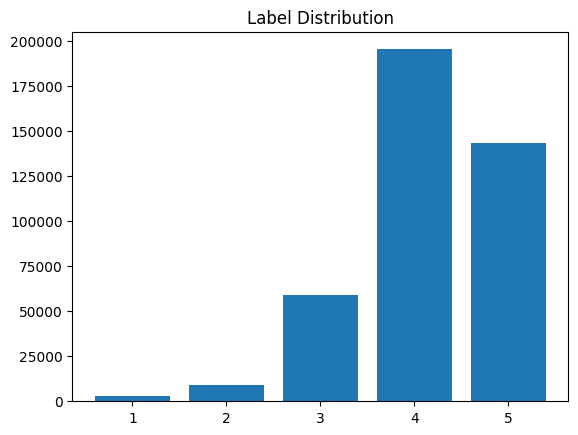

In [18]:
# Chart labels
rating_count = rating_count["own_id"].to_numpy()
ratings = range(1, 6)

# Show pie chart
plt.title("Label Distribution")
plt.bar(x=ratings, height=rating_count)
plt.show()

### Data Splitting

##### Creating user profile

In [19]:
df_history = df_history.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features = pd.merge(df_history, df_inf_norm, left_on='inf_id', right_on='id', how='left')
df_inf_features.head()

,own_id,inf_id,combined_rating,id,avg_rating,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1,1,0.808,1,0.725916,0,0,1,1,0,...,0,1,0,0,1,0,0,1,0,0
1,1,3,0.584,3,0.658073,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
2,1,5,0.972,5,0.751696,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,1,6,1.000,6,0.910448,1,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0
4,1,7,0.776,7,0.854817,1,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0


In [20]:
OWNER_FEATURES = df_inf_norm.columns[1:]

# Copy influencer features combined with history data
df_own_norm = df_inf_features.copy()

# Multiply influencer feature with user rating
df_own_norm[OWNER_FEATURES] = df_own_norm[OWNER_FEATURES].mul(df_own_norm['combined_rating'], axis=0) 

# Drop unimportant features
df_own_norm = df_own_norm.drop(["inf_id", "id", "combined_rating"], axis=1)

# Average those with same owner id to make user profile
df_own_norm = df_own_norm.groupby('own_id').mean().reset_index()
df_own_norm.rename(columns={'own_id': 'id'}, inplace=True)

df_own_norm = df_own_norm.drop(['avg_rating'], axis=1)
df_own_norm.head()

,id,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1,0.545000,0.000000,0.295500,0.309000,0.000000,0.374500,0.541500,0.216000,0.434500,...,0.440500,0.840500,0.0,0.000000,0.840500,0.0,0.000000,0.840500,0.0,0.000000
1,2,0.462334,0.032486,0.382869,0.376729,0.185119,0.417301,0.200170,0.251623,0.252754,...,0.246675,0.782018,0.0,0.095672,0.809617,0.0,0.068073,0.580511,0.0,0.297179
2,3,0.585529,0.000000,0.297176,0.262353,0.220471,0.530471,0.246471,0.239765,0.254706,...,0.190706,0.831176,0.0,0.051529,0.882706,0.0,0.000000,0.610000,0.0,0.272706
3,4,0.709951,0.000000,0.114829,0.626634,0.264683,0.389951,0.135805,0.326927,0.306244,...,0.383220,0.805659,0.0,0.019122,0.805659,0.0,0.019122,0.805659,0.0,0.019122
4,5,0.617409,0.000000,0.198000,0.285409,0.141818,0.434591,0.219909,0.177000,0.224273,...,0.272682,0.806682,0.0,0.008727,0.806682,0.0,0.008727,0.736500,0.0,0.078909


##### Process feature and label

Influencer features

In [21]:
# Remove ID and labels
df_inf_features = df_inf_features.drop(["own_id", "inf_id", "id"], axis=1)

df_inf_features.head()

,combined_rating,avg_rating,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,0.808,0.725916,0,0,1,1,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0
1,0.584,0.658073,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
2,0.972,0.751696,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
3,1.000,0.910448,1,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0
4,0.776,0.854817,1,0,0,0,0,1,1,0,...,1,1,0,0,1,0,0,1,0,0


In [22]:
df_inf_features_pos = df_inf_features[df_inf_features["combined_rating"] > 0.6].drop(["combined_rating"], axis=1)
df_inf_features_neg = df_inf_features[df_inf_features["combined_rating"] <= 0.6].drop(["combined_rating"], axis=1)

df_inf_features_pos

,avg_rating,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,0.725916,0,0,1,1,0,1,0,1,1,...,0,1,0,0,1,0,0,1,0,0
2,0.751696,0,0,1,0,0,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0
3,0.910448,1,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0
4,0.854817,1,0,0,0,0,1,1,0,1,...,1,1,0,0,1,0,0,1,0,0
5,0.957938,1,0,0,0,0,0,1,1,1,...,1,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409707,0.926730,1,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
409708,0.848033,1,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
409709,0.947083,1,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
409710,0.762551,1,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


In [23]:
INFLUENCER_FEATURE_COUNT = len(df_inf_features.drop("combined_rating", axis=1).columns)

Owner features

In [24]:
# Join history and owner data by own_id
df_own_features = pd.merge(df_history, df_own_norm, left_on='own_id', right_on='id', how='left')

df_own_features.head()

,own_id,inf_id,combined_rating,id,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1,1,0.808,1,0.545,0.0,0.2955,0.309,0.0,0.3745,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
1,1,3,0.584,1,0.545,0.0,0.2955,0.309,0.0,0.3745,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
2,1,5,0.972,1,0.545,0.0,0.2955,0.309,0.0,0.3745,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
3,1,6,1.000,1,0.545,0.0,0.2955,0.309,0.0,0.3745,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
4,1,7,0.776,1,0.545,0.0,0.2955,0.309,0.0,0.3745,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0


In [25]:
# Remove ID and labels
df_own_features = df_own_features.drop(["own_id", "inf_id", "id"], axis=1)

df_own_features.head()

,combined_rating,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,0.808,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
1,0.584,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
2,0.972,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
3,1.000,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
4,0.776,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0


In [26]:
df_own_features_pos = df_own_features[df_own_features["combined_rating"] > 0.6].drop(["combined_rating"], axis=1)
df_own_features_neg = df_own_features[df_own_features["combined_rating"] <= 0.6].drop(["combined_rating"], axis=1)

df_own_features_pos

,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,School,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
2,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
3,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
4,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
5,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,...,0.4405,0.8405,0.0,0.0,0.8405,0.0,0.0,0.8405,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409707,0.950,0.0,0.0000,0.950,0.0,0.0000,0.2300,0.000,0.0000,0.240,...,0.0000,0.9500,0.0,0.0,0.9500,0.0,0.0,0.9500,0.0,0.0
409708,0.950,0.0,0.0000,0.950,0.0,0.0000,0.2300,0.000,0.0000,0.240,...,0.0000,0.9500,0.0,0.0,0.9500,0.0,0.0,0.9500,0.0,0.0
409709,0.950,0.0,0.0000,0.950,0.0,0.0000,0.2300,0.000,0.0000,0.240,...,0.0000,0.9500,0.0,0.0,0.9500,0.0,0.0,0.9500,0.0,0.0
409710,0.950,0.0,0.0000,0.950,0.0,0.0000,0.2300,0.000,0.0000,0.240,...,0.0000,0.9500,0.0,0.0,0.9500,0.0,0.0,0.9500,0.0,0.0


In [27]:
OWNER_FEATURE_COUNT = len(df_own_features.drop("combined_rating", axis=1).columns)

Labels

In [28]:
# Get labels from history data
df_labels = df_history["combined_rating"]
df_labels.head()

0    0.808
1    0.584
2    0.972
3    1.000
4    0.776
Name: combined_rating, dtype: float64

In [29]:
df_labels_pos = df_labels[df_labels > 0.6]
df_labels_neg = df_labels[df_labels <= 0.6]

df_labels_pos

0         0.808
2         0.972
3         1.000
4         0.776
5         0.920
          ...  
409707    0.960
409708    0.928
409709    0.920
409710    0.992
409711    1.000
Name: combined_rating, Length: 358181, dtype: float64

##### Generate train, validation, and test dataset

In [30]:
SHUFFLE_BUFFER = 1000

dataset = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features, "own_feature": df_own_features}, df_labels))
dataset = dataset.shuffle(SHUFFLE_BUFFER) 

dataset.element_spec

({'inf_feature': TensorSpec(shape=(24,), dtype=tf.float64, name=None),
  'own_feature': TensorSpec(shape=(23,), dtype=tf.float64, name=None)},
 TensorSpec(shape=(), dtype=tf.float64, name=None))

In [31]:
# Generate training, validation, and testing data
DATASET_SIZE = dataset.cardinality().numpy()
TRAIN_SIZE = int(DATASET_SIZE * 0.9)
VAL_SIZE = int(DATASET_SIZE * 0.05)
TEST_SIZE = DATASET_SIZE - TRAIN_SIZE - VAL_SIZE

train_dataset = dataset.take(TRAIN_SIZE)
val_dataset = dataset.skip(TRAIN_SIZE).take(VAL_SIZE)
test_dataset = dataset.skip(TRAIN_SIZE + VAL_SIZE).take(TEST_SIZE)

print(f"Training dataset has {train_dataset.cardinality().numpy()} data")
print(f"Validation dataset has {val_dataset.cardinality().numpy()} data")
print(f"Testing dataset has {test_dataset.cardinality().numpy()} data")

Training dataset has 368740 data
Validation dataset has 20485 data
Testing dataset has 20487 data


In [32]:
# Batching
REPEAT = 2

train_dataset = train_dataset.batch(BATCH_SIZE).repeat(REPEAT)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

##### Generate train, validation, and test dataset (positive and negative)

In [33]:
SHUFFLE_BUFFER = 1000

dataset_pos = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features_pos, "own_feature": df_own_features_pos}, df_labels_pos))
dataset_pos = dataset_pos.shuffle(SHUFFLE_BUFFER) 
dataset_neg = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features_neg, "own_feature": df_own_features_neg}, df_labels_neg))
dataset_neg = dataset_neg.shuffle(SHUFFLE_BUFFER) 

print("Positive data:", dataset_pos.element_spec)
print("Count positive data:", dataset_pos.cardinality().numpy())

print("\nNegative data:", dataset_neg.element_spec)
print("Count negative data:", dataset_neg.cardinality().numpy())

Positive data: ({'inf_feature': TensorSpec(shape=(23,), dtype=tf.float64, name=None), 'own_feature': TensorSpec(shape=(22,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.float64, name=None))
Count positive data: 358181

Negative data: ({'inf_feature': TensorSpec(shape=(23,), dtype=tf.float64, name=None), 'own_feature': TensorSpec(shape=(22,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.float64, name=None))
Count negative data: 51531


In [34]:
# Generate training, validation, and testing data
POSITIVE_SIZE = dataset_pos.cardinality().numpy()
TRAIN_POS_SIZE = int(POSITIVE_SIZE * 0.9)
VAL_POS_SIZE = int(POSITIVE_SIZE * 0.05)
TEST_POS_SIZE = POSITIVE_SIZE - TRAIN_POS_SIZE - VAL_POS_SIZE

train_dataset_pos = dataset_pos.take(TRAIN_POS_SIZE)
val_dataset_pos = dataset_pos.skip(TRAIN_POS_SIZE).take(VAL_POS_SIZE)
test_dataset_pos = dataset_pos.skip(TRAIN_POS_SIZE + VAL_POS_SIZE).take(TEST_POS_SIZE)

print(f"Positive training dataset has {train_dataset_pos.cardinality().numpy()} data")
print(f"Positive validation dataset has {val_dataset_pos.cardinality().numpy()} data")
print(f"Positive testing dataset has {test_dataset_pos.cardinality().numpy()} data")

Positive training dataset has 322362 data
Positive validation dataset has 17909 data
Positive testing dataset has 17910 data


In [35]:
# Generate training, validation, and testing data
NEGATIVE_SIZE = dataset_neg.cardinality().numpy()
TRAIN_NEG_SIZE = int(NEGATIVE_SIZE * 0.5)
VAL_NEG_SIZE = int(NEGATIVE_SIZE * 0.25)
TEST_NEG_SIZE = NEGATIVE_SIZE - TRAIN_NEG_SIZE - VAL_NEG_SIZE

train_dataset_neg = dataset_neg.take(TRAIN_NEG_SIZE)
val_dataset_neg = dataset_neg.skip(TRAIN_NEG_SIZE).take(VAL_NEG_SIZE)
test_dataset_neg = dataset_neg.skip(TRAIN_NEG_SIZE + VAL_NEG_SIZE).take(TEST_NEG_SIZE)

print(f"Negative training dataset has {train_dataset_neg.cardinality().numpy()} data")
print(f"Negative validation dataset has {val_dataset_neg.cardinality().numpy()} data")
print(f"Negative testing dataset has {test_dataset_neg.cardinality().numpy()} data")

Negative training dataset has 25765 data
Negative validation dataset has 12882 data
Negative testing dataset has 12884 data


In [36]:
train_dataset = train_dataset_pos.concatenate(train_dataset_neg)
val_dataset = val_dataset_pos.concatenate(val_dataset_neg)
test_dataset = test_dataset_pos.concatenate(test_dataset_neg)

print(f"Training dataset has {train_dataset.cardinality().numpy()} data")
print(f"Validation dataset has {val_dataset.cardinality().numpy()} data")
print(f"Testing dataset has {test_dataset.cardinality().numpy()} data")

Training dataset has 348127 data
Validation dataset has 30791 data
Testing dataset has 30794 data


In [37]:
# Batching
REPEAT = 2

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Creating Model

Model consists of two neural networks that would be combined with Dot layer. The first neural network has influencer features as input and a vector as an output. The second one has owner features as input and a vector as an output. These two vectors will be combined with Dot layer and produces a single combined rating

In [38]:
VECTOR_SIZE = 128
# tf.random.set_seed(1)

model_influencer = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=VECTOR_SIZE, activation='linear'),
])

# create the influencer input and point to the base network
input_influencer = tf.keras.layers.Input(shape=(INFLUENCER_FEATURE_COUNT), name="inf_feature")
vi = model_influencer(input_influencer)
vi = tf.linalg.l2_normalize(vi, axis=1)

model_owner = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=VECTOR_SIZE, activation='linear'),
])

# create the owner input and point to the base network
input_owner = tf.keras.layers.Input(shape=(OWNER_FEATURE_COUNT), name="own_feature")
vo = model_owner(input_owner)
vo = tf.linalg.l2_normalize(vo, axis=1)

# compute the dot product of the two vectors vi and vo
output = tf.keras.layers.Dot(axes=1)([vi, vo])

# specify the inputs and output of the model
model = tf.keras.Model([input_influencer, input_owner], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inf_feature (InputLayer)       [(None, 23)]         0           []                               
                                                                                                  
 own_feature (InputLayer)       [(None, 22)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 128)          357184      ['inf_feature[0][0]']            
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          455168      ['own_feature[0][0]']            
                                                                                              

In [39]:
import time

start_time = time.time()
model.compile(optimizer= OPTIMIZER, 
              loss=LOSS_FN,
              metrics=["mse", "mae"])

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCH)
end_time = time.time()
training_time = end_time - start_time

Epoch 1/300
680/680 [==============================] - 20s 27ms/step - loss: 0.4873 - mse: 0.4873 - mae: 0.6621 - val_loss: 0.0403 - val_mse: 0.0403 - val_mae: 0.1702
Epoch 2/300
680/680 [==============================] - 18s 27ms/step - loss: 0.1568 - mse: 0.1568 - mae: 0.3617 - val_loss: 0.0581 - val_mse: 0.0581 - val_mae: 0.1972
Epoch 3/300
680/680 [==============================] - 18s 27ms/step - loss: 0.0672 - mse: 0.0672 - mae: 0.2268 - val_loss: 0.0741 - val_mse: 0.0741 - val_mae: 0.2235
Epoch 4/300
680/680 [==============================] - 18s 27ms/step - loss: 0.0391 - mse: 0.0391 - mae: 0.1641 - val_loss: 0.0845 - val_mse: 0.0845 - val_mae: 0.2374
Epoch 5/300
680/680 [==============================] - 19s 28ms/step - loss: 0.0285 - mse: 0.0285 - mae: 0.1339 - val_loss: 0.0907 - val_mse: 0.0907 - val_mae: 0.2453
Epoch 6/300
680/680 [==============================] - 20s 30ms/step - loss: 0.0243 - mse: 0.0243 - mae: 0.1213 - val_loss: 0.0938 - val_mse: 0.0938 - val_mae: 0.249

KeyboardInterrupt: 

In [ ]:
def plot_history(history, save=False):
    # Extract the loss, MAE, and MSE values from the history object
    loss = history.history['loss']
    mse = history.history['mse']
    mae = history.history['mae']
    val_loss = history.history['val_loss']
    val_mse = history.history['val_mse']
    val_mae = history.history['val_mae']

    # Create a figure and set up the subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

    # Plot the loss history
    plt.title(REMARK)
    ax1.plot(loss, label='Loss')
    ax1.plot(val_loss, label='Val Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the MSE history
    ax2.plot(mse, label='MSE')
    ax2.plot(val_mse, label='Val MSE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MSE')
    ax2.legend()

    # Plot the MAE history
    ax3.plot(mae, label='MAE')
    ax3.plot(val_mae, label='Val MAE')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MAE')
    ax3.legend()

    # Show the plot
    plt.tight_layout()
    if (save):
        if (not os.path.exists(os.path.join(PLOT_DIR, LOG_NAME))):
            plt.savefig(os.path.join(PLOT_DIR, LOG_NAME))
    
    plt.show()

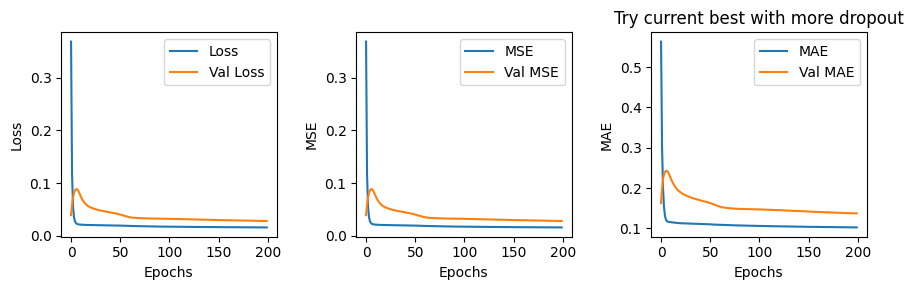

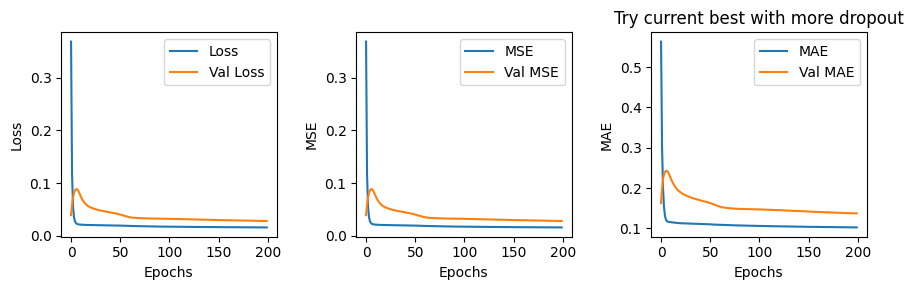

In [ ]:
plot_history(history)
plot_history(history, save=True)


### Evaluation with test dataset

In [ ]:
test_predict = model.predict(test_dataset)
test_predict

61/61 [==============================] - 1s 4ms/step


array([[0.77780944],
       [0.67656463],
       [0.7506879 ],
       ...,
       [0.6079181 ],
       [0.7525328 ],
       [0.70576006]], dtype=float32)

In [ ]:
# Get real label
test_labels = np.array([])
for batch in test_dataset:
    test_labels = np.concatenate([test_labels, batch[1].numpy()])

test_labels

array([0.772, 0.988, 0.816, ..., 0.588, 0.576, 0.364])

In [ ]:
compare_test = pd.concat([pd.DataFrame(test_predict, columns=["predicted"]), 
                     pd.DataFrame(test_labels, columns=["real"])], axis=1)

compare_test["error"] = abs(compare_test["predicted"] - compare_test["real"])

compare_test

,predicted,real,error
0,0.777809,0.772,0.005809
1,0.676565,0.988,0.311435
2,0.750688,0.816,0.065312
3,0.759743,0.764,0.004257
4,0.797577,0.764,0.033577
...,...,...,...
30789,0.709817,0.572,0.137817
30790,0.673112,0.392,0.281112
30791,0.607918,0.588,0.019918
30792,0.752533,0.576,0.176533


In [ ]:
compare_test[compare_test["error"] >= 1e-1]

,predicted,real,error
1,0.676565,0.988,0.311435
5,0.782864,0.976,0.193136
6,0.639298,0.756,0.116702
7,0.661924,0.976,0.314076
8,0.808823,0.976,0.167177
...,...,...,...
30788,0.727152,0.600,0.127152
30789,0.709817,0.572,0.137817
30790,0.673112,0.392,0.281112
30792,0.752533,0.576,0.176533


In [ ]:
train_predict = model.predict(train_dataset)
train_predict

680/680 [==============================] - 2s 3ms/step


array([[0.824328  ],
       [0.7895119 ],
       [0.7898214 ],
       ...,
       [0.5062493 ],
       [0.69892997],
       [0.5905373 ]], dtype=float32)

In [ ]:
# Get real label
train_labels = np.array([])
for batch in train_dataset:
    train_labels = np.concatenate([train_labels, batch[1].numpy()])

train_labels

array([0.924, 0.932, 0.828, ..., 0.2  , 0.564, 0.564])

In [ ]:
compare_train = pd.concat([pd.DataFrame(train_predict, columns=["predicted"]), 
                     pd.DataFrame(train_labels, columns=["real"])], axis=1)

compare_train["error"] = abs(compare_train["predicted"] - compare_train["real"])

compare_train

,predicted,real,error
0,0.824328,0.924,0.099672
1,0.789512,0.932,0.142488
2,0.789821,0.828,0.038179
3,0.795460,0.980,0.184540
4,0.820878,0.760,0.060878
...,...,...,...
348122,0.620288,0.400,0.220288
348123,0.539602,0.600,0.060398
348124,0.506249,0.200,0.306249
348125,0.698930,0.564,0.134930


In [ ]:
compare_train[compare_train["error"] >= 4e-1]

,predicted,real,error
585,0.560995,0.996,0.435005
1004,0.537188,0.984,0.446812
1156,0.572316,0.988,0.415684
1161,0.588122,1.000,0.411878
1182,0.501600,0.960,0.458400
...,...,...,...
348075,0.778777,0.364,0.414777
348079,0.657201,0.224,0.433201
348100,0.663961,0.120,0.543961
348106,0.760023,0.324,0.436023


## Logging

In [ ]:
if (not os.path.exists(os.path.join(MODEL_DIR, LOG_NAME))):
    tf.saved_model.save(model, os.path.join(MODEL_DIR, LOG_NAME))

INFO:tensorflow:Assets written to: log/model/savedmodel/recommender-avgrating-moredropout\assets


INFO:tensorflow:Assets written to: log/model/savedmodel/recommender-avgrating-moredropout\assets


In [ ]:
if (not os.path.exists(os.path.join(KERAS_DIR, LOG_NAME))):
    model.save(os.path.join(KERAS_DIR, LOG_NAME))

INFO:tensorflow:Assets written to: log/model/keras/recommender-avgrating-moredropout\assets


INFO:tensorflow:Assets written to: log/model/keras/recommender-avgrating-moredropout\assets


In [ ]:
def serialize(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        raise TypeError("Object of type {} is not JSON serializable".format(type(obj)))

In [ ]:
import json
from datetime import timedelta

log = {
    "name": LOG_NAME,
    "training_time": str(timedelta(training_time)),
    "remark": REMARK,
    "test_error": compare_test["error"].mean(),
    "results": {
        "last_loss": history.history["loss"][-1],
        "last_mae": history.history["mae"][-1],
        "last_mse": history.history["mse"][-1],
        "last_val_loss": history.history["val_loss"][-1],
        "last_val_mae": history.history["val_mae"][-1],
        "last_val_mse": history.history["val_mse"][-1],
    },
    "hyperparameter": {
        "learning_rate": LEARNING_RATE,
        "epoch": EPOCH,
        "batch_size": BATCH_SIZE,
        "loss_func": tf.keras.losses.serialize(LOSS_FN)["class_name"],
        "optimizer": tf.keras.optimizers.serialize(OPTIMIZER)["class_name"],
    },
    "data_distribution": {
        "positive": POSITIVE_SIZE,
        "negative": NEGATIVE_SIZE,
        "training_pos": TRAIN_POS_SIZE,
        "training_neg": TRAIN_NEG_SIZE,
    },
    "data_example": {
        "influencer": df_influencer.head().to_dict(),
        "owner": df_own_norm.head().to_dict(),
        "history": df_history.head().to_dict(),
    },
    "eval": {
        "loss": history.history["loss"],
        "mae": history.history["mae"],
        "mse": history.history["mse"],
        "val_loss": history.history["val_loss"],
        "val_mae": history.history["val_mae"],
        "val_mse": history.history["val_mse"],
    }
}
if (not os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME + ".json"))):
    with open(os.path.join(DETAIL_DIR, LOG_NAME + '.json'), 'w') as json_file:
        log = json.dumps(log, default=serialize)
        json_file.write(log)

In [ ]:
summary = model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inf_feature (InputLayer)       [(None, 23)]         0           []                               
                                                                                                  
 own_feature (InputLayer)       [(None, 22)]         0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 64)           90368       ['inf_feature[0][0]']            
                                                                                                  
 sequential_5 (Sequential)      (None, 64)           184256      ['own_feature[0][0]']            
                                                                                            

In [ ]:
from contextlib import redirect_stdout

with open(os.path.join(SUMMARY_DIR, LOG_NAME + ".txt"), 'w') as f:
    with redirect_stdout(f):
        print("Influencer Model:")
        model_influencer.summary()
        
        print("\nOwner Model:")
        model_owner.summary()
        
        print("\nFull Model:")
        model.summary()